In [1]:
options(warn=0)

In [2]:
#export 
source("exp/nb_01.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘survival’ was built under R version 4.1.1”
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [3]:
library(mlr)
library(survival)

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.



## Load datasets

In [4]:
dfs = readRDS(paste(data_path,"dfs_filtered.rds", sep=""))
#dfs = readRDS("../data/dfs_filtered_for_feature_selection.rds")
names(dfs)

[1] "METABRIC" "GSE11121" "GSE96058" "GSE7390"  "GSE9893"  "NKI"      "TCGA"    
[8] "GSE4922"

## Normailze datasets

In [5]:
zscore = function(x){(x - mean(x))/sd(x)}

In [6]:
first_cols = c(53, 61, 117, 100, 85, 31, 107, 75)

for (n in 1:8){
    dfs[[n]] = dfs[[n]] %>%
        as_tibble() %>%
        mutate(across(c(first_cols[n]:dim(dfs[[n]])[2]), zscore))}

## Select common genes

In [7]:
df_names = map(1:8, function(i) colnames(dfs[[i]]))
common_genes = Reduce(intersect,  df_names)
length(common_genes)

[1] 3973

In [8]:
common_genes = common_genes[-c(1,4,5,6,7)]

In [9]:
for (n in 1:8){dfs[[n]] = dfs[[n]][,common_genes]}

In [10]:
df_merged = bind_rows(dfs, .id = "id")

In [11]:
dim(df_merged)

[1] 2553 3969

In [12]:
df_merged = df_merged[is.na(df_merged$survival_time)==FALSE,]
dim(df_merged)

[1] 2549 3969

In [13]:
df_merged = df_merged %>% 
  mutate_if(is.numeric, ~replace_na(.,mean(., na.rm = TRUE)))
dim(df_merged)

[1] 2549 3969

In [14]:
df_merged$id = as.factor(df_merged$id)

In [15]:
df_merged[1:5,1:20]

id,survival_time,event,RPS28,PDE4DIP,CCNE2,COL17A1,HMG20B,CD69,SPP1,HBE1,MFN2,DCK,FOXI1,COX11,CYP26A1,GADD45G,ABCD4,SEMA3E,AQP3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
METABRIC,10.000000,0,-0.96191276,-0.6387181,0.9895475,-0.9627129,-2.1999668,0.2327361,0.3861117,0.2304193,0.32011566,0.04182810,-0.2097966,-1.5597079,0.4856915,0.7986725,0.1817340,-0.5786585,0.42905840
METABRIC,8.436111,0,0.07474009,-1.8065609,-0.3265120,0.3448196,-1.1314446,1.1428240,0.9982856,0.5025724,0.35740511,-0.50447804,-0.3310581,-0.2509069,-0.8877473,-2.4506967,1.3981037,-0.4284744,1.60696458
METABRIC,8.547222,0,-0.33780567,-0.3414163,-1.2184269,1.1358373,-2.0181939,0.2566022,-0.6897213,-0.7878149,0.03616281,0.42664790,-0.5882329,-0.2321952,-0.9601604,-1.0858200,0.4241296,-0.6009477,-0.01219052
METABRIC,9.550000,0,0.44974403,0.4955736,-1.1034863,0.5794090,-0.7627214,0.7689174,1.1276506,-0.6456764,-1.67838988,-0.06753056,0.1193351,0.4559516,0.1469346,0.9110501,-0.6276686,1.0841288,-0.36808435
METABRIC,7.177778,0,-0.17430498,-1.5742359,0.6715751,-0.7440335,-0.1080593,0.4374500,0.1674362,0.6380339,-0.09106640,1.44645719,0.6242486,1.1531171,-0.5534119,0.8869530,1.2616305,-0.0749494,-0.15209601


In [143]:
#df_merged[1:5,1:20]

In [153]:
#df_merged = df_merged %>%
#        mutate(across(c(4:dim(df_merged)[2]), zscore))

In [154]:
table(df_merged$event)


   0    1 
2163  386 

In [155]:
386./2163
386./(386+2163)

[1] 0.1784558

[1] 0.1514319

## Modelling

In [16]:
sample_signature = function(df, size = 20){
    if(!is.data.frame(df)) stop("df must be data frame!")
    i = 4
    e = dim(df)[2]
    indxs = sample_ints(i, e, size)
    genes = c("id", names(df)[indxs])
    list(indxs = indxs, genes = genes, cols4cox = c("survival_time", "event", genes))
}

replace_nas = function(m){
    m %>% mutate_all(~replace(., is.nan(.), 1))
}

#export
sample_list_of_signatures = function(df, n = 100, size = 10){
    l = vector("list", n)
    for (i in 1:n){
        signature = sample_signature(df, size = size)
        tmp = df[, signature$cols4cox]
        #colnames(tmp) = c("survival_time", "event", paste0("G", 1:(dim(tmp)[2]-2)))
        l[[i]] = replace_nas(tmp)
    }
    l
}

get_cindex = function(data){
    cindex = resample("surv.coxph", 
                  makeSurvTask(data = data, target = c("survival_time", "event")), 
                  makeResampleDesc(method="CV", iters=5, stratify=TRUE), 
                  models=TRUE, 
                  show.info = F)[[6]][[1]]
cindex
}

downsample_df = function(df){
  df_event = df[df$event==1,]
  n = 2*nrow(df_event)
  df_control = df[sample(nrow(df), n), ]
  rbind(df_event, df_control)
}


In [17]:
as.integer(15.1*100)

[1] 1510

In [18]:
downsample_df = function(df, nsubjects){
  nevents = as.integer(0.15*nsubjects)
  ncontrols = nsubjects-nevents
  df_event =   df[df$event==1,]
  df_control = df[df$event==0,]
  df_event = sample_n(df_event, nevents)
  df_control = sample_n(df_control, ncontrols)  
  rbind(df_event, df_control)
}

In [301]:
dim(df_merged)

[1] 2549 3969

In [73]:
saveRDS(object = df_merged,  file = "../data/df_merged.rds")

In [307]:
df = downsample_df(df_merged, 1000)
dim(df)
table(df$event)

[1] 1000 3969


  0   1 
850 150 

In [269]:
head(df)

$indxs
 [1] 1299 2625 2027 3551 2501 3328 1507 2833 3225  471 2460 1056  976 2764 2278
[16] 2509 2409 3357 1897 2339

$genes
 [1] "id"       "BCAT2"    "PLSCR4"   "OLIG2"    "LHX2"     "WNT8B"   
 [7] "DPYD"     "GPR12"    "SERPINB7" "PDLIM1"   "MB"       "PPP1R11" 
[13] "PLXNB3"   "SOX13"    "MFNG"     "PIPOX"    "USP20"    "TCF15"   
[19] "NCF2"     "CTNNAL1"  "MSC"     

$cols4cox
 [1] "survival_time" "event"         "id"            "BCAT2"        
 [5] "PLSCR4"        "OLIG2"         "LHX2"          "WNT8B"        
 [9] "DPYD"          "GPR12"         "SERPINB7"      "PDLIM1"       
[13] "MB"            "PPP1R11"       "PLXNB3"        "SOX13"        
[17] "MFNG"          "PIPOX"         "USP20"         "TCF15"        
[21] "NCF2"          "CTNNAL1"       "MSC"

In [160]:
rs = sample_list_of_signatures(df_merged, n = 10, size = 20)

In [162]:
head(rs[[1]])

survival_time,event,PUM1,P4HB,DUSP5,BYSL,ECEL1,PTGER4,PPL,AKT1,⋯,NQO1,DDIT3,UCP3,PRKDC,FBXO11,ABCA2,PIN4,CDH18,HRAS,CDC25C
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.000000,0,0.43310346,-1.38763861,0.02405004,0.99491486,-0.18385792,0.06763846,-1.1729765,-0.7627287,⋯,-0.1772061,-0.10289780,0.09904878,0.2277177,-1.6718249,-0.45335579,-0.8423862,-0.2666576,-1.6873503,0.02368672
8.436111,0,0.88893054,0.31545692,1.13089149,0.09318832,-0.60317622,-0.25251368,2.2420691,-1.3745384,⋯,0.1276363,0.37803424,-1.47619428,-0.7007732,0.1100236,-0.07078176,-1.0862711,-0.3914534,-0.8052475,-0.26981912
8.547222,0,-0.01719321,0.02855575,-0.52252257,-1.24446267,0.95946884,0.88208256,0.2205732,-0.6763414,⋯,-1.6055765,0.50075672,-0.44328992,-1.3497776,-0.1825928,0.22829614,-0.1731996,-0.4692066,-1.0339488,-1.52820328
9.550000,0,0.43982895,-1.27377943,-0.91593493,-0.31238841,0.30154499,0.24235926,0.4506965,-1.1981685,⋯,0.3440527,0.74042727,0.34058866,-0.2696323,-1.2338238,-1.33678808,-0.4133153,0.4270950,-0.2745989,-1.71210107
7.177778,0,0.41478036,0.81722792,-0.28823057,0.86449855,0.04536559,0.02674907,1.4884139,-0.8423929,⋯,0.3396173,-0.01038268,-0.54622548,0.4163745,-1.1114955,-0.54105174,1.4447749,-0.1682424,-0.1842136,-0.04396248
10.000000,0,0.14786458,-0.06479660,-0.49684341,-0.64991353,-0.37026046,-0.55105100,-0.5340962,-0.3769624,⋯,-0.1403383,-0.90316706,-0.24479021,-1.0123479,0.3773323,-0.88453258,-0.4285213,3.1906914,-1.2012102,-0.92161041


In [260]:
df_merged[1:5,1:10]

id,survival_time,event,RPS28,PDE4DIP,CCNE2,COL17A1,HMG20B,CD69,SPP1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
METABRIC,10.000000,0,-0.96191276,-0.6387181,0.9895475,-0.9627129,-2.1999668,0.2327361,0.3861117
METABRIC,8.436111,0,0.07474009,-1.8065609,-0.3265120,0.3448196,-1.1314446,1.1428240,0.9982856
METABRIC,8.547222,0,-0.33780567,-0.3414163,-1.2184269,1.1358373,-2.0181939,0.2566022,-0.6897213
METABRIC,9.550000,0,0.44974403,0.4955736,-1.1034863,0.5794090,-0.7627214,0.7689174,1.1276506
METABRIC,7.177778,0,-0.17430498,-1.5742359,0.6715751,-0.7440335,-0.1080593,0.4374500,0.1674362


In [18]:
N = 25 # number of genes to sample
μs = vector("list", N)
σs = vector("list", N)
cs = vector("list", N)

In [19]:
for (i in 2:N){
    print(i)
    df = downsample_df(df_merged, (i*100))
    rs = sample_list_of_signatures(df, n = 1000, size = 20)
    cindices = unlist(map(rs, get_cindex))
    cs[[i]] = cindices 
    μs[[i]] = median(cindices)
    σs[[i]] = sd(cindices)  
}

[1] 2


ERROR: Error in downsample_df(df_merged, (i * 100)): could not find function "downsample_df"


In [16]:
cs

ERROR: Error in eval(expr, envir, enclos): object 'cs' not found


In [15]:
μs = map(cs, median)

ERROR: Error in map(cs, median): object 'cs' not found


In [65]:
a = 8
CIs = tibble(inds = ((a:25)*100), Mean = as.numeric(μs[a:25]), SD = as.numeric(σs[a:25]), Cindices = cindices[a:25])

In [66]:
#saveRDS(object = CIs, file = "../data/cindices_from_resampling_merged_data_1000times.rds")

## Results

In [7]:
CIs = readRDS("../data/cindices_from_resampling_merged_data_1000times.rds")

In [13]:
dim(CIs)

[1] 24  4

In [14]:
CIs$Cindices

[1] 0.6600610 0.6706102 0.6667615 0.6399427 0.6672347 0.6516475 0.6584340
 [8] 0.6640575 0.6435488 0.6461035 0.6584679 0.6831579 0.6837379 0.6589291
[15] 0.6632740 0.6513775 0.6533655 0.6713703 0.6600119 0.6571157 0.6776933
[22] 0.6614989 0.6482663 0.6590668

In [12]:
head(CIs)

inds,Mean,SD,Cindices
<dbl>,<dbl>,<dbl>,<dbl>
200,0.5429313,0.06498191,0.6600610
300,0.6211850,0.03992523,0.6706102
400,0.6511884,0.03680274,0.6667615
500,0.5803630,0.04415151,0.6399427
600,0.6142188,0.02883380,0.6672347
700,0.6456288,0.02575981,0.6516475


In [8]:
theme_set(theme_bw())

In [9]:
#ggplot(CIs, aes(x=inds, y=Mean)) +
#   # geom_line(size=0.1) +
#    geom_point(shape=21, size=8) +
#    geom_smooth(method = "lm", size=0.4)+
#    xlab("Number of genes") +
#    ylab("Mean C-index")+ stat_cor(method = "pearson", label.x = 10, label.y = 0.55)

In [10]:
FONT = "Helvetica"
FONTSIZE = 12

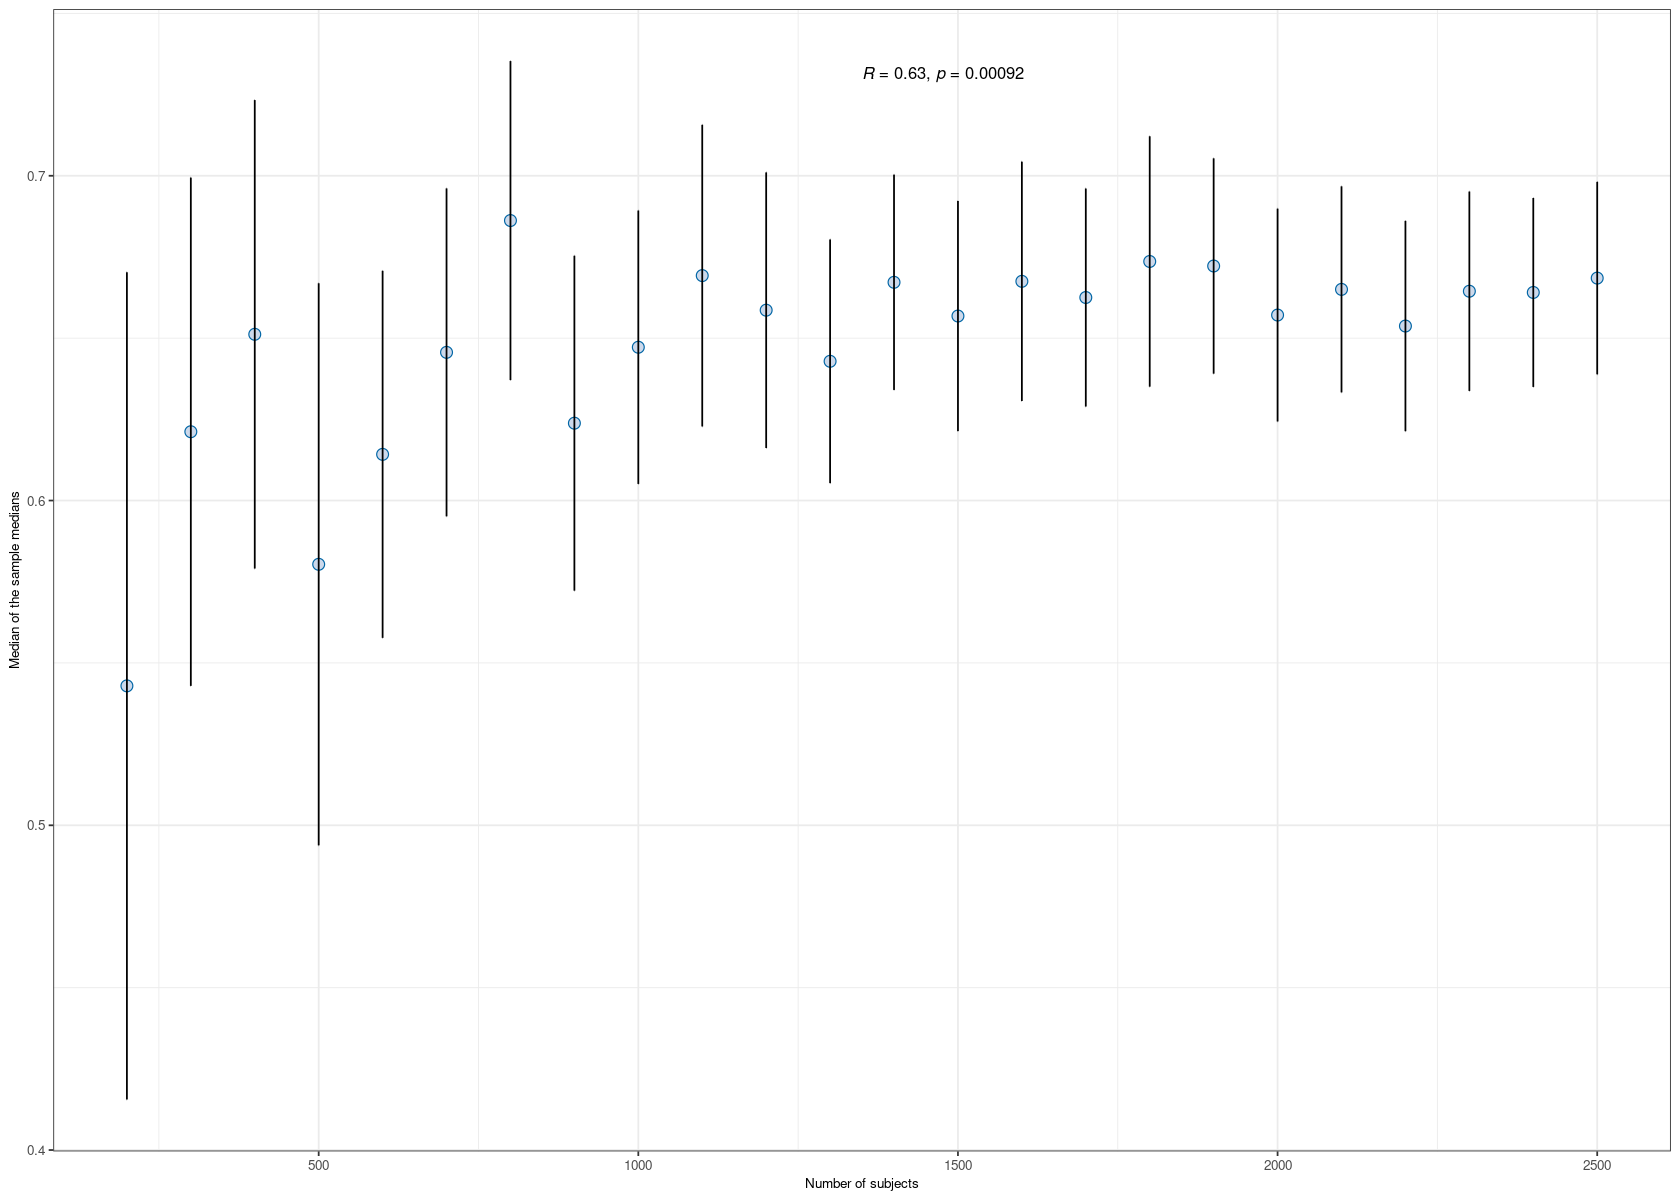

In [11]:
P = ggplot(CIs, aes(x=inds, y=Mean)) + 
   geom_point(color=rgb(0, 101, 165, maxColorValue=255), 
                 fill=rgb(205, 217, 235, maxColorValue=255),
                 pch=21, 
                 size=3,
                 stroke = 0.5
                )+
  #scale_x_continuous(trans='log10')+
  stat_cor(method = "pearson", label.x.npc = "middle",label.y.npc = "top", size=3.5) +
  geom_errorbar(aes(ymin=Mean-1.96*SD, ymax=Mean+1.96*SD), width=.4,
                 position=position_dodge(1.9))+ 
  xlab("Number of subjects")+
  ylab("Median of the sample medians")+
#   expand_limits(y = c(0.5, 1.2))  
  theme(
      axis.text.x = element_text(family=FONT, size = 23/.pt),
      axis.text.y = element_text(family=FONT, size = 23/.pt),
      text=element_text(family=FONT,          size = 23/.pt))+
  theme(strip.text.y = element_text(angle = 0))
P

In [71]:
path = "../figures/"

In [72]:
ggsave(filename = "si_mom_merged_random.tiff", path = path, width = 17.8, height = 17.8*(2/3), units = "cm", device='tiff', dpi=700)
ggsave(filename = "si_mom_merged_random.png",  path = path, width = 17.8, height = 17.8*(2/3), units = "cm", device='png',  dpi=700)